In [22]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import os

## Leitura e limpeza do csv com colunas específicas

In [23]:
def leitor_csv_zip(caminho_zip: str, colunas: list[str]) -> pd.DataFrame:
    """
    Lê um CSV de dentro de um arquivo .zip, usando apenas as colunas necessárias.
    """
    try:
        with zipfile.ZipFile(caminho_zip, 'r') as z:
            # lista todos os arquivos dentro do zip
            arquivos = z.namelist()
            # pega só os que terminam com .csv
            csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

            if not csvs:
                print(f"Nenhum arquivo .csv encontrado dentro de {caminho_zip}")
                return pd.DataFrame()

            # por simplicidade, vamos usar o primeiro CSV encontrado
            csv_principal = csvs[0]
            print(f"Lendo {csv_principal} de dentro de {caminho_zip}")

            with z.open(csv_principal) as f:
                quadro = pd.read_csv(f, usecols=colunas, low_memory=False)

        # Padroniza colunas para minúsculas, igual ao leitor de .csv solto
        quadro.columns = [c.lower() for c in quadro.columns]
        return quadro

    except Exception as e:
        print(f"Erro ao ler {caminho_zip}: {e}")
        return pd.DataFrame()


def leitor_geral_especifico_zip(caminhos_zip: list[str], colunas: list[str]) -> pd.DataFrame:
    """
    Lê vários .zip (cada um contendo um CSV de dengue) e concatena tudo em um único DataFrame.
    """
    dados_finais = pd.DataFrame()

    for caminho in caminhos_zip:
        quadro = leitor_csv_zip(caminho, colunas)
        if not quadro.empty:
            dados_finais = pd.concat([dados_finais, quadro], ignore_index=True)

    print(f"Total de linhas após leitura geral (zip): {len(dados_finais)}")
    print(f"Colunas do DataFrame final: {list(dados_finais.columns)}")
    return dados_finais

def converter_datas(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Converte DT_SIN_PRI e DT_NOTIFIC para datetime.
    """
    if "dt_sin_pri" in quadro.columns:
        quadro["dt_sin_pri"] = pd.to_datetime(
            quadro["dt_sin_pri"],
            errors="coerce"
        )

    if "dt_notific" in quadro.columns:
        quadro["dt_notific"] = pd.to_datetime(
            quadro["dt_notific"],
            errors="coerce"
        )

    return quadro

def filtrar_ano_minimo(quadro: pd.DataFrame, ano_minimo: int = 2020) -> pd.DataFrame:
    """
    Remove linhas com NU_ANO menor que 'ano_minimo' (padrão: 2020).

    Útil para descartar notificações de 2019 que aparecem no CSV de 2020,
    mas que não queremos considerar na análise 2020–2025.
    """
    if "nu_ano" not in quadro.columns:
        print("Aviso: coluna 'nu_ano' não encontrada. Nenhum filtro de ano aplicado.")
        return quadro

    # Garante que nu_ano é numérico
    quadro["nu_ano"] = pd.to_numeric(quadro["nu_ano"], errors="coerce")

    antes = len(quadro)
    quadro_filtrado = quadro[quadro["nu_ano"] >= ano_minimo].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar ano >= {ano_minimo}: {antes} -> {depois} linhas.")
    return quadro_filtrado

## Filtragem classificados com dengue

In [24]:
# Remove casos com classi_fin considerado descartado
def filtrar_classificados(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Remove casos descartados (CLASSI_FIN == 5).
    """
    if "classi_fin" not in quadro.columns:
        print("Aviso: coluna 'classi_fin' não encontrada. Nenhum filtro aplicado.")
        return quadro

    quadro["classi_fin"] = pd.to_numeric(quadro["classi_fin"], errors="coerce")
    antes = len(quadro)
    quadro_filtrado = quadro[quadro["classi_fin"] != 5].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar classificados: {antes} -> {depois} linhas (descartados removidos).")
    return quadro_filtrado

## Perfil demografico

In [25]:
def idade_para_anos(codigo):
    if pd.isna(codigo):
        return None  # ou np.nan, se preferir

    codigo = int(codigo)
    unidade = codigo // 1000        # primeiro dígito
    valor = codigo % 1000           # últimos três dígitos

    if unidade == 1:  # horas
        return 0
    elif unidade == 2:  # dias
        return 0
    elif unidade == 3:  # meses
        return valor // 12
    elif unidade == 4:  # anos
        return valor

    return None


def faixa_etaria(idade_em_anos: int) -> str:
    """
    Converte a idade para uma faixa etária.
    """
    #idade_em_anos = idade_para_anos(idade)

    if pd.isna(idade_em_anos) or idade_em_anos <= 0:
        return "Desconhecida"
    
    elif idade_em_anos <= 14:
        return "0-14"
    elif idade_em_anos <= 29:
        return "15-29"
    elif idade_em_anos <= 45:
        return "30-45"
    elif idade_em_anos <= 59:
        return "46-59"
    else:
        return "60+"
    

def perfil_demografico_brasil(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Analisa o perfil demográfico (idade e sexo) dos casos de dengue,
    segmentando por faixa etária e sexo, além de calcular a proporção de casos graves.
    """
    df = quadro.copy()

    # Criação da coluna 'faixa_etaria' a partir de 'NU_IDADE_N'
    df['idade'] = df['nu_idade_n'].apply(idade_para_anos)
    df['faixa_etaria'] = df['idade'].apply(faixa_etaria)

    # Filtrando apenas os casos graves
    casos_graves = df[df['classi_fin'] == 12]

    # Contagem por faixa etária e sexo
    perfil_geral = df.groupby(['faixa_etaria', 'cs_sexo']).size().reset_index(name='total')
    perfil_graves = casos_graves.groupby(['faixa_etaria', 'cs_sexo']).size().reset_index(name='total_graves')

    # Merge para ter o perfil geral e o de casos graves na mesma tabela
    perfil = pd.merge(perfil_geral, perfil_graves, on=['faixa_etaria', 'cs_sexo'], how='left')
    perfil['proporcao_graves'] = perfil['total_graves'] / perfil['total']

    return perfil

## Perfil por ano

In [26]:
def perfil_por_ano_brasil(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Analisa a evolução do perfil demográfico ao longo do tempo.
    """
    df = quadro.copy()

    # Criação da coluna 'faixa_etaria' a partir de 'NU_IDADE_N'
    df['faixa_etaria'] = df['nu_idade_n'].apply(faixa_etaria)

    # Filtrando apenas os casos graves
    casos_graves = df[df['classi_fin'] == 12]

    # Contagem por ano, faixa etária e sexo
    perfil_geral_ano = df.groupby(['nu_ano', 'faixa_etaria', 'cs_sexo']).size().reset_index(name='total')
    perfil_graves_ano = casos_graves.groupby(['nu_ano', 'faixa_etaria', 'cs_sexo']).size().reset_index(name='total_graves')

    # Merge para ter o perfil geral e o de casos graves na mesma tabela
    perfil_ano = pd.merge(perfil_geral_ano, perfil_graves_ano, on=['nu_ano', 'faixa_etaria', 'cs_sexo'], how='left')
    perfil_ano['proporcao_graves'] = perfil_ano['total_graves'] / perfil_ano['total']

    return perfil_ano

## Graficos

In [27]:
def grafico_perfil_demografico(perfil_df: pd.DataFrame):
    """
    Gráfico de barras mostrando o perfil demográfico (faixa etária e sexo)
    e a proporção de casos graves.
    """
    if perfil_df.empty:
        print("Perfil demográfico vazio – nenhum gráfico gerado.")
        return

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=perfil_df,
        x="faixa_etaria",
        y="proporcao_graves",
        hue="cs_sexo",
        ci=None
    )

    plt.title("Proporção de casos graves por faixa etária e sexo")
    plt.xlabel("Faixa Etária")
    plt.ylabel("Proporção de Casos Graves")
    plt.tight_layout()
    plt.show()


def grafico_perfil_por_ano(perfil_ano_df: pd.DataFrame):
    """
    Gráfico de barras empilhadas por ano, faixa etária e sexo,
    mostrando a distribuição dos casos graves.
    """
    if perfil_ano_df.empty:
        print("Perfil por ano vazio – nenhum gráfico gerado.")
        return

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=perfil_ano_df,
        x="nu_ano",
        y="proporcao_graves",
        hue="faixa_etaria",
        errorbar=None
    )

    plt.title("Proporção de casos graves por ano e faixa etária")
    plt.xlabel("Ano")
    plt.ylabel("Proporção de Casos Graves")
    plt.tight_layout()
    plt.show()

## Execução completa

Lendo DENGBR20.csv de dentro de dados/DENGBR20.zip
Lendo DENGBR21.csv de dentro de dados/DENGBR21.zip
Lendo DENGBR22.csv de dentro de dados/DENGBR22.zip
Lendo DENGBR23.csv de dentro de dados/DENGBR23.zip
Lendo DENGBR24.csv de dentro de dados/DENGBR24.zip
Lendo DENGBR25.csv de dentro de dados/DENGBR25.zip
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'id_mn_resi', 'municipio', 'classi_fin']
Filtrar classificados: 13344402 -> 12327380 linhas (descartados removidos).
Filtrar ano >= 2020: 12327380 -> 12323901 linhas.

Perfil demográfico (idade e sexo) dos casos de dengue – Brasil: TESTE
    faixa_etaria cs_sexo    total  total_graves  proporcao_graves
0           0-14       F   842928         571.0          0.000677
1           0-14       I     2294           NaN               NaN
2           0-14       M   982254         765.0          0.000779
3          15-29       F 

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_12840\1585518180.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


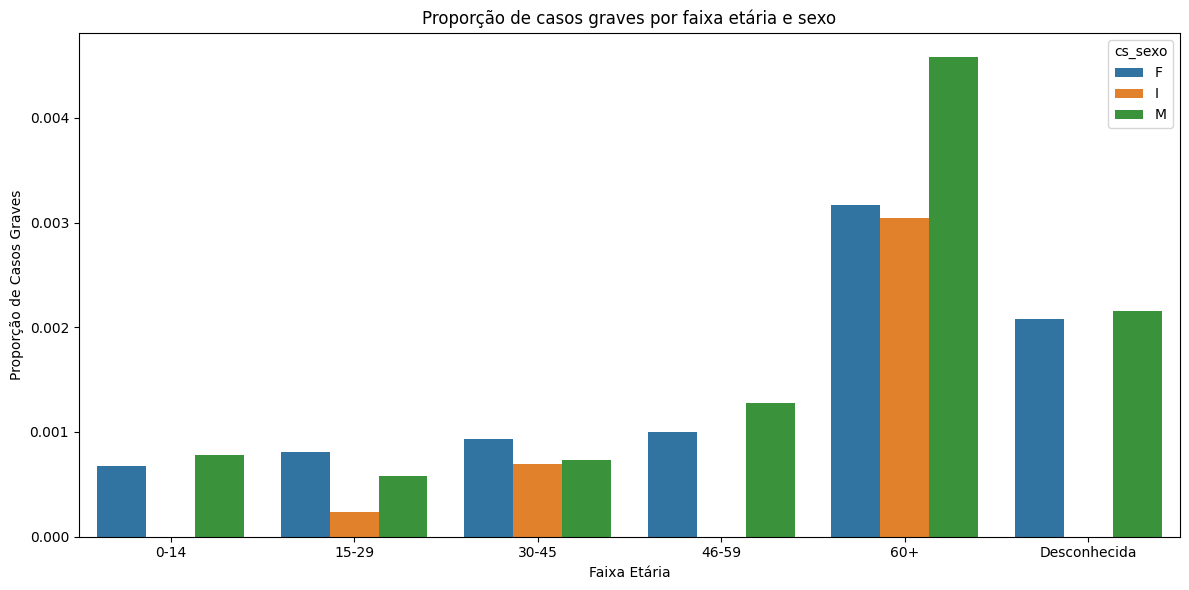

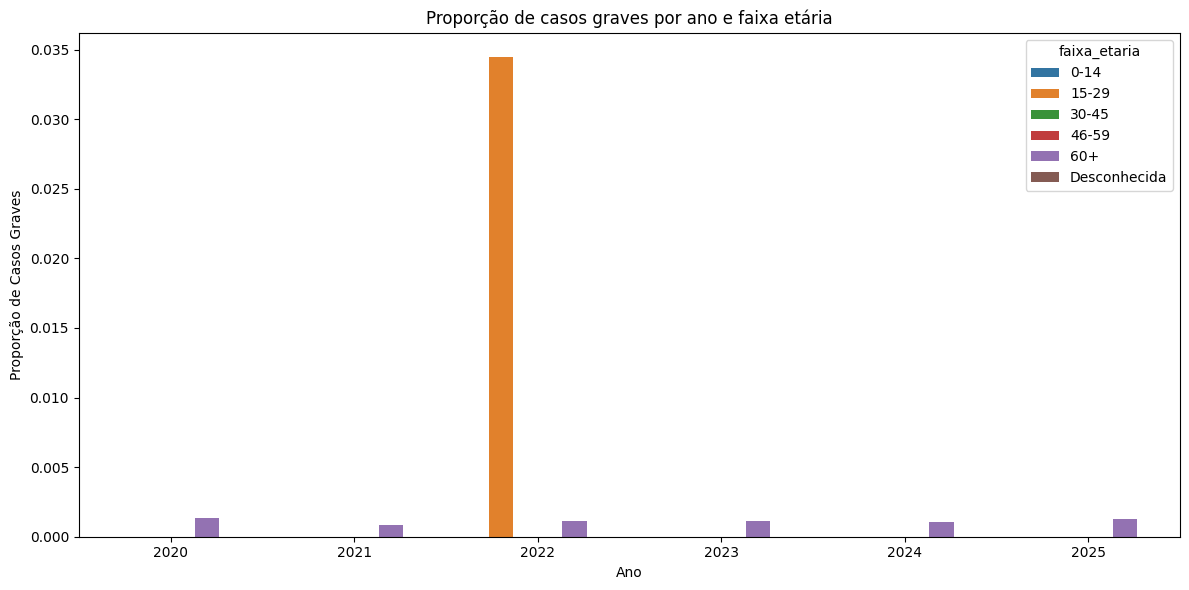

In [28]:
def executar_perfil_demografico_brasil(caminhos_zip: list[str], colunas_necessarias: list[str]):
    # 1) Leitura e limpeza
    dados = leitor_geral_especifico_zip(caminhos_zip, colunas_necessarias)
    dados = converter_datas(dados)
    dados = filtrar_classificados(dados)
    dados = filtrar_ano_minimo(dados, ano_minimo=2020)

    # 2) Perfil demográfico
    perfil = perfil_demografico_brasil(dados)

    print("\nPerfil demográfico (idade e sexo) dos casos de dengue – Brasil: TESTE")
    print(perfil)

    # 3) Perfil por ano
    perfil_ano = perfil_por_ano_brasil(dados)

    print("\nPerfil demográfico por ano – Brasil:")
    print(perfil_ano)

    # 4) Gráficos
    grafico_perfil_demografico(perfil)
    grafico_perfil_por_ano(perfil_ano)


caminhos_zip = [
    "dados/DENGBR20.zip",
    "dados/DENGBR21.zip",
    "dados/DENGBR22.zip",
    "dados/DENGBR23.zip",
    "dados/DENGBR24.zip",
    "dados/DENGBR25.zip",
]

colunas_necessarias = [
    "DT_NOTIFIC",
    "SEM_NOT",
    "NU_ANO",
    "SG_UF_NOT",
    "DT_SIN_PRI",
    "NU_IDADE_N",
    "CS_SEXO",
    "CLASSI_FIN",
    "ID_MN_RESI",
    "MUNICIPIO"
]

executar_perfil_demografico_brasil(caminhos_zip, colunas_necessarias)